# Multi-class Doggo Breed Classification

We will build a multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem Definition

Identifying the breed of a dog given an image of a dog.

When I see a dog and happen to take a picture of it, I would love to know what breed it is. As I'm trying out this project, I barely have any knowledge on dog breeds and it would help to know more about these cute fluffs.

## 2. Data

The data we're using is from Kaggle's Dog Breed Identification competition: 

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation 

The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some information about the data:
* We are dealing with images (unstructured data). It is best to use 
deep learning and transfer learning for such cases.

* There are 120 breeds of dogs that I barely know of (120 classes).

* There are around 10K+ images in the training set (the images have labels)

* There are around 10k+ images in the test set (no labels, because we are trying to predict them).


In [0]:
#Used this line to unzip the data into google drive (comment out once done)
#!unzip "/content/drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "/content/drive/My Drive/Dog Vision/"

# Getting the workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we are using a GPU

In [39]:
#Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available! :D" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.2.0
TF Hub version: 0.8.0
GPU available! :D


### In case TensorFlow needs to be updated

In [0]:
#%tensorflow_version only exists in Colab
#try:
 # %tensorflow_version 2.x
  #except Exception:
   # pass

## Getting our data ready (turning into Tensors)

Our data has to be turned into numerical format before we can move on.

In [41]:
#Checkout the labels of the data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     bb7fdde5ce18544f51b1091f8f14533f  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [42]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

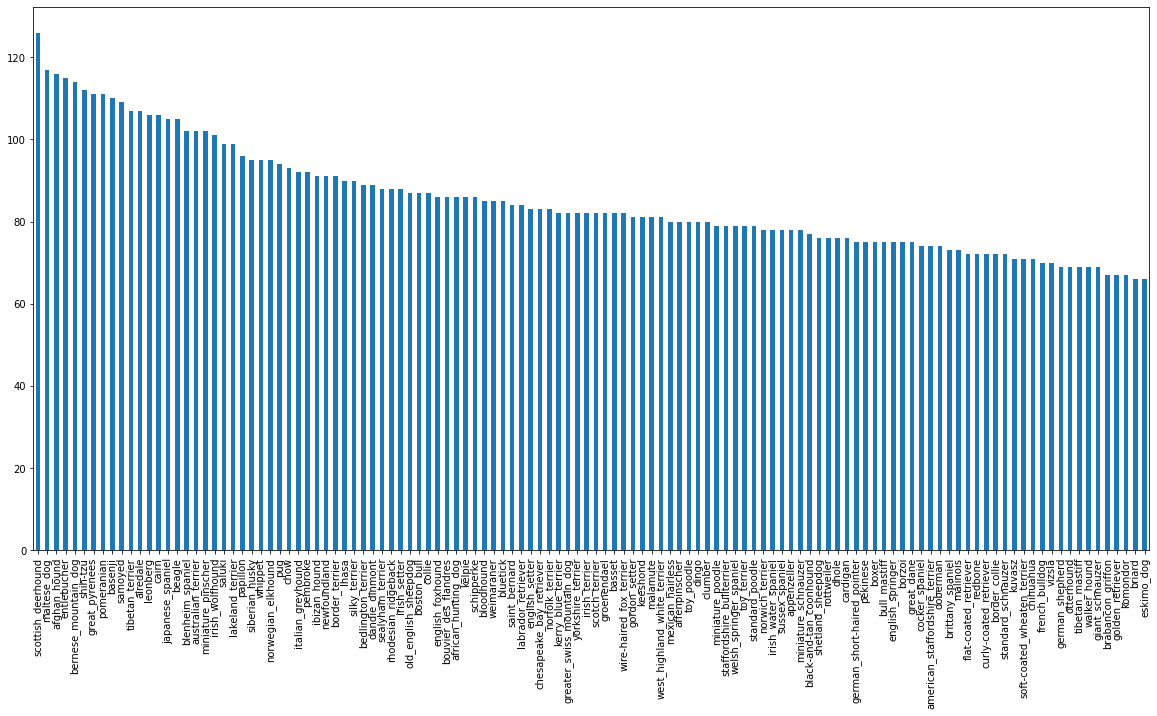

In [43]:
# How many images are there of each bread?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [44]:
labels_csv["breed"].value_counts().median()

82.0

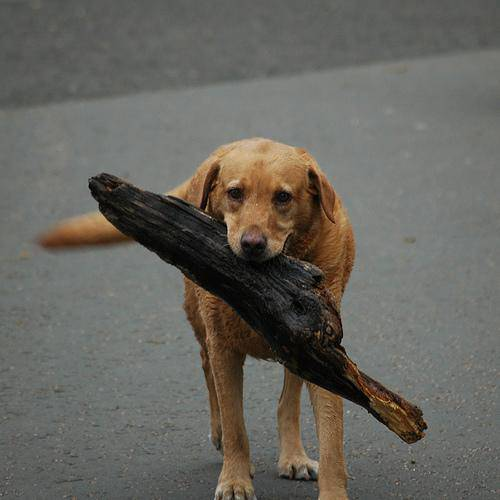

In [45]:
#Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

In [46]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [47]:
# Check that number of filenames matches number of actual image files
import os 
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files :D")
else:
    print("Filenames do not match actual amount of files, check target directory")

Filenames match actual amount of files :D


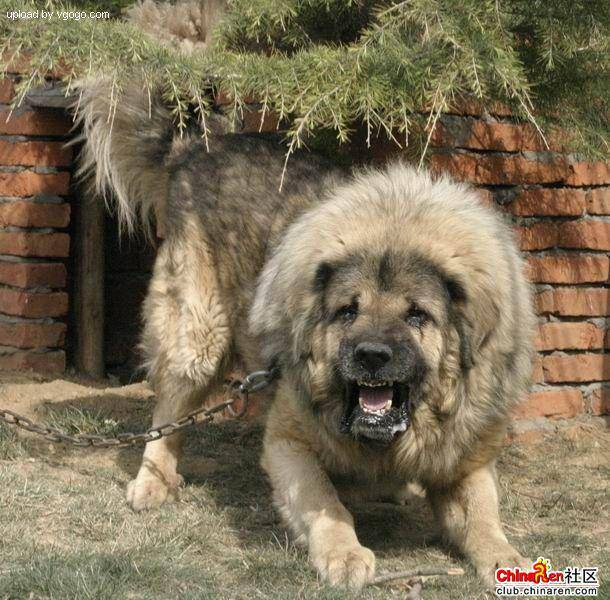

In [48]:
# One more check
Image(filenames[9000])

In [49]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've got our training image filepaths in a list, let's prepare our labels.

In [50]:
import numpy as np 
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [51]:
len(labels)

10222

In [52]:
# Check number of labels matches number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames :D")
else:
  print("Number of labels does not match number of filenames, check data categories.")


Number of labels matches number of filenames :D


In [53]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [54]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [55]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [56]:
len(boolean_labels)

10222

In [57]:
# Example: Turning boolean array into integers
print (labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since Kaggle's dataset does not come with a validation set, we will make our own.

In [0]:
# Setup X & y 
X = filenames
y = boolean_labels

We are going to start with around 1000 images and incrase as needed to save time.

In [0]:
# Setup number of images to use for experimenting
NUM_IMAGES = 1000 #@param{type:"slider", min:1000, max:10000, step:1000}

In [60]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val) 

(800, 800, 200, 200)

In [61]:
X_train[:5], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, **image**
3. Turn our **image** (a jpg) into Tensors
4. Normalize our **image** (convert colour channel values from 0-255 to 0-1).
5. Resize the **image** to be a shape of (224,224)
6. Return the modified **image**

Let's see what importing an image looks like first.

In [62]:
# Convert image to numpy
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [63]:
image.max(), image.min() # the colour varies from 0 to 255

(255, 0)

In [64]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [65]:
# Turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

In [0]:
# Define image size 
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  #Turn the jpeg image into numerical tensor with 3 colour channels (RGB)
  image = tf.image.decode_jpeg(image,channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32) 
  #Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image




## Turning our data into batches 

Why turn our data into batches?

Let's say you're trying to process 10K+ images in one shot, they might not all fit into memory.

We will make batches to process 32 images at a time (or any) other number).

In order to use TensorFlow effectively, we need the data in the form of Tensor tuples which look like: (image, label) 

In [0]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [68]:
# Demo 
(process_image(X[42])), tf.constant(y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of tensors in the form: **(image, label)**. Let's make a function to turn all our data (X & y) into batches. 

In [0]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [70]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches
Creating validation data batches


In [71]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them.

In [0]:
import matplotlib.pyplot as plt
# Create a function for viewing images in data batch
def show_25_images(images,labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    #Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5,5,i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [73]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.6030713 , 0.629862  , 0.50806326],
          [0.5306723 , 0.50630254, 0.38417372],
          [0.60066026, 0.60847336, 0.5814726 ],
          ...,
          [0.7913949 , 0.74553657, 0.7517288 ],
          [0.8877728 , 0.8510887 , 0.853889  ],
          [0.9242393 , 0.8557019 , 0.8478186 ]],
 
         [[0.6881053 , 0.6830833 , 0.590076  ],
          [0.6883353 , 0.65472186, 0.5435174 ],
          [0.59223694, 0.5815927 , 0.5359344 ],
          ...,
          [0.90033996, 0.9084632 , 0.93227273],
          [0.68781954, 0.6909913 , 0.7164513 ],
          [0.7575632 , 0.7269007 , 0.7172168 ]],
 
         [[0.77556026, 0.7392057 , 0.67194885],
          [0.8000401 , 0.7625051 , 0.6678272 ],
          [0.6318328 , 0.60550225, 0.5520008 ],
          ...,
          [0.6375257 , 0.65461266, 0.66637737],
          [0.61077386, 0.6041015 , 0.6182076 ],
          [0.6051819 , 0.5672766 , 0.521008  ]],
 
         ...,
 
         [[0.47189793, 0.44472736, 0.4208878 ],
          [0.52683

In [74]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

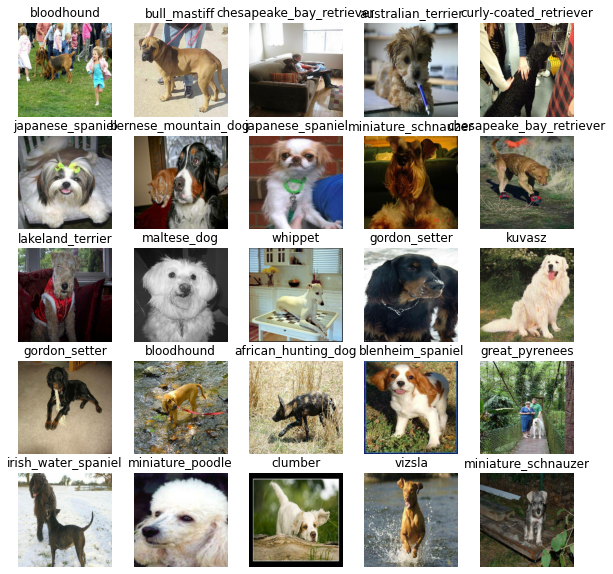

In [75]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

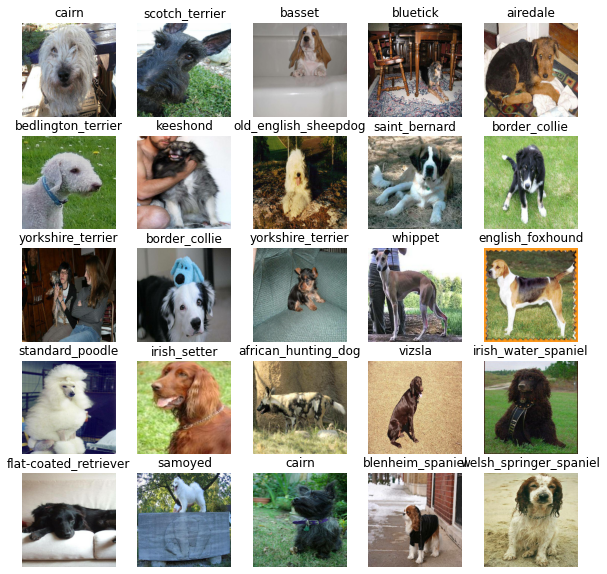

In [76]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape( our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4.

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE,3] # batch, height, width, colour channels

# setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs and model ready to go.
Let's put them together into a Keras deep learning model.

Knowing this, let's create a function which: 
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion.
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview


In [0]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  #Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layer 1 (input layers)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                      activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [79]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things: 
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callaback which is able to save logs to a directory and pass it to our model's **fit()** function.
3. Visualize our models training logs with the **tensorboard** magic function (after model training).

In [0]:
# Loard TensorBoard notebook extension
%load_ext tensorboard

import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        #Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps top our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


In [0]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

## Training a model (on a subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100,step:10}


In [83]:
# Check to make sure we're still running on a GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available


Let's create a function which trains a model.

* Create a model using **create_model()**
* Steup a TensorBoard callback using **create_tensorboard_callback()**
* Call the **fit()** function on our model passing it the training data, validation data, number of epochs to train for (**NUM_EPOCHS**) and the callbacks we would like to use
* Return the model

In [0]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """

  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callback we created 
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  #Return the fitted model
  return model

In [107]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 520s 21s/step - loss: 4.6638 - accuracy: 0.0975 - val_loss: 3.4349 - val_accuracy: 0.2750
Epoch 2/100
25/25 [==============================] - 7s 261ms/step - loss: 1.6928 - accuracy: 0.6825 - val_loss: 2.2387 - val_accuracy: 0.4800
Epoch 3/100
25/25 [==============================] - 7s 261ms/step - loss: 0.5802 - accuracy: 0.9337 - val_loss: 1.7394 - val_accuracy: 0.5650
Epoch 4/100
25/25 [==============================] - 6s 260ms/step - loss: 0.2628 - accuracy: 0.9875 - val_loss: 1.5649 - val_accuracy: 0.6000
Epoch 5/100
25/25 [==============================] - 7s 280ms/step - loss: 0.1509 - accuracy: 0.9962 - val_loss: 1.4813 - val_accuracy: 0.6150
Epoch 6/100
25/25 [==============================] - 7s 260ms/step - loss: 0.1028 - accuracy: 0.9987 - val_loss: 1.4249 - val_accuracy: 0.6300
Epoch 7/100
25/25 [==============================

**Question:** 
Our model seems to be overfitting because it's performing way better on the training set than the validation set. What are some ways to prevent model overfitting in deep learning neural networks?

Overfitting in this case is a good thing. It means our model is identifying patterns and learning.

### Checking the TensorBoard logs

The TensorBoard magic function (**%tensorboard**) will access the logs directory we created earlier and visualize its content.

In [108]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs

Output hidden; open in https://colab.research.google.com to view.

## Making and evaluating predicitons using a trained model

In [85]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 82s 12s/step


array([[8.1942021e-04, 1.6437874e-03, 3.4232771e-03, ..., 8.2049640e-03,
        3.8905793e-03, 9.2673894e-05],
       [9.6704683e-04, 6.4664125e-03, 4.2854842e-02, ..., 9.8498445e-03,
        1.9303613e-03, 1.0332474e-03],
       [8.1701586e-03, 1.2995829e-03, 2.8956102e-02, ..., 1.6309898e-03,
        4.9198358e-03, 4.4802143e-03],
       ...,
       [8.3111599e-03, 1.9836174e-03, 1.2033191e-02, ..., 2.8930423e-03,
        7.6666497e-02, 8.7554026e-03],
       [1.4811695e-03, 4.3933649e-04, 8.6069608e-04, ..., 8.7439707e-03,
        9.8131457e-04, 2.9064761e-04],
       [7.8340033e-03, 1.1911468e-02, 2.0116784e-03, ..., 6.7278519e-02,
        2.2302957e-03, 5.0342674e-03]], dtype=float32)

In [116]:
np.sum(predictions[1]) #numbers should add up close to 1 

0.9999999

In [122]:
# First prediction
index=0
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.18522102e-03 7.83113210e-05 4.61545569e-04 2.23640032e-04
 1.27956519e-04 7.36684815e-05 2.24986281e-02 3.71896109e-04
 1.24181490e-04 4.50246735e-04 5.41855174e-04 6.30492286e-04
 1.36977949e-04 2.67098920e-04 5.55748557e-05 5.07736229e-04
 1.72710643e-05 2.93425620e-01 4.78744951e-05 2.82457535e-04
 7.17311108e-04 1.97464120e-04 1.73319931e-04 4.31768224e-03
 1.24037397e-04 2.69174296e-03 2.28884578e-01 3.70976020e-04
 3.14184836e-05 8.34292514e-05 2.73513549e-04 7.63468503e-04
 2.45201797e-03 1.83603170e-05 9.49904133e-05 6.78257272e-03
 2.88990232e-05 6.51608978e-04 2.75763159e-04 2.17467881e-04
 1.78592221e-03 2.07242902e-05 1.98189155e-04 1.64081619e-04
 3.40552033e-05 3.66004206e-05 4.17046649e-05 3.23975983e-04
 6.03742548e-04 9.20100720e-04 3.28949536e-04 2.98641302e-04
 2.17510082e-04 9.89396212e-05 4.33556299e-04 4.30419313e-05
 8.08978861e-04 3.19501036e-03 2.63711816e-04 1.50577515e-01
 1.40430324e-03 2.51496785e-05 9.76654585e-04 4.72922875e-05
 4.45784244e-04 1.502974

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence intervals

In [87]:
# Turn prediction probabilities into their respective labels (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'saluki'

Now since our validation data is still in a batch dataset, we will have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [88]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image,label) Tensors and retunrs separate arrays of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels
  # Unbatchify validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make function to make these all a bit more visual.

We will create a function which:
* Takes an arary of prediction probabilities, an array of truth labels and an array of imags and integers.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

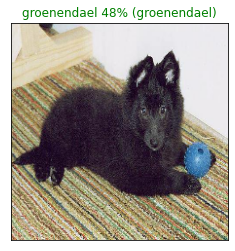

In [163]:

plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we have a function to visualize our models top prediction, let's make another to view our models top 10 predictions

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the prediction using **get_pred_label()**
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, colouring the true label green

In [0]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediciton confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels==true_label)].set_color("green")
  else:
    pass


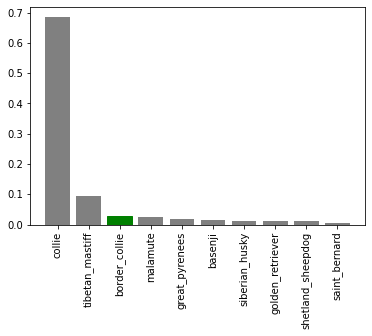

In [170]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few.

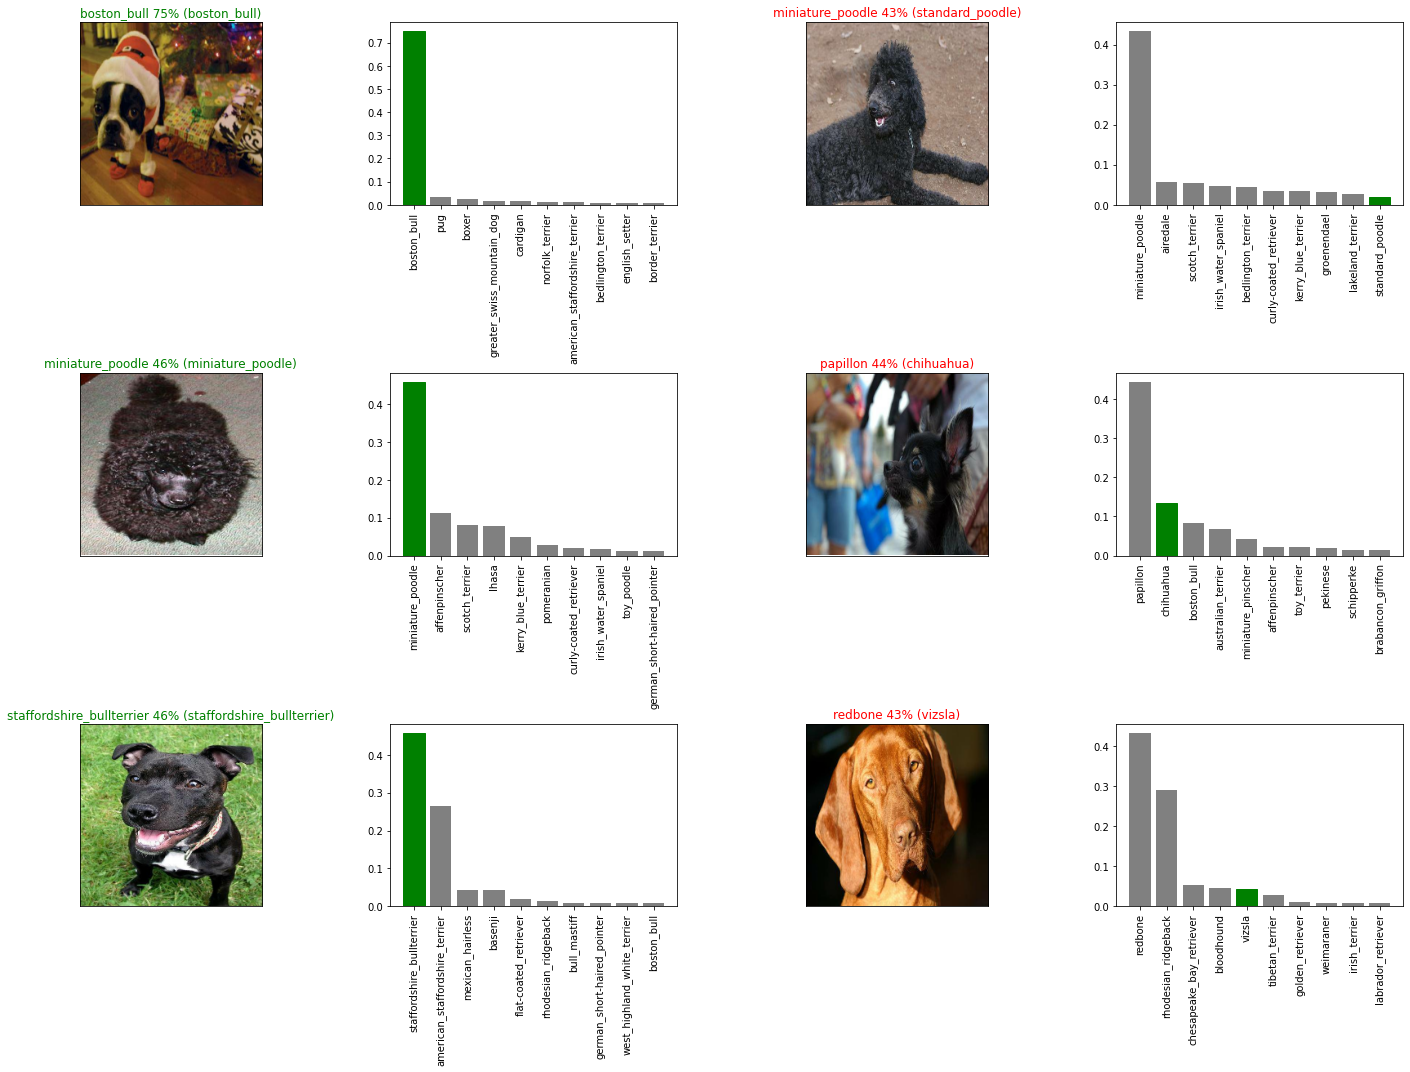

In [198]:
# Let's check out a few predictions and their different values
i_multiplier = 46
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a trained model

In [0]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work.

In [213]:
# Save our model trained on 1000 images 
save_model(model, suffix="1000-images-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200603-21251591219556-1000-images-Adam.h5...


'drive/My Drive/Dog Vision/models/20200603-21251591219556-1000-images-Adam.h5'

In [214]:
# Load a trained model
loaded_1000_image_model = load_model('drive/My Drive/Dog Vision/models/20200603-21251591219556-1000-images-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20200603-21251591219556-1000-images-Adam.h5


In [215]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 148ms/step - loss: 1.3614 - accuracy: 0.6250


[1.3613826036453247, 0.625]

In [216]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 150ms/step - loss: 1.3614 - accuracy: 0.6250


[1.3613826036453247, 0.625]

## Training on more Good Boys (training on full data)

In [217]:
len(X), len(y)

(10222, 10222)

In [218]:
len(X_train)

800

In [219]:
# Create a data batch with the full data set
full_data = create_data_batches(X,y)

Creating training data batches


In [220]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [221]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# There is no validation set when training on all the data, so we cannot monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

**Note:** Fitting the full model with the full data will definitely take longer than our smaller model from earlier.

In [225]:
# Fit the full model to the full data
full_model.fit(x=full_data, 
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 5508s 17s/step - loss: 1.3222 - accuracy: 0.6686
Epoch 2/100
320/320 [==============================] - 65s 203ms/step - loss: 0.4040 - accuracy: 0.8820
Epoch 3/100
320/320 [==============================] - 65s 202ms/step - loss: 0.2382 - accuracy: 0.9355
Epoch 4/100
320/320 [==============================] - 65s 203ms/step - loss: 0.1547 - accuracy: 0.9635
Epoch 5/100
320/320 [==============================] - 65s 204ms/step - loss: 0.1059 - accuracy: 0.9793
Epoch 6/100
320/320 [==============================] - 65s 202ms/step - loss: 0.0791 - accuracy: 0.9860
Epoch 7/100
320/320 [==============================] - 64s 200ms/step - loss: 0.0596 - accuracy: 0.9909
Epoch 8/100
320/320 [==============================] - 64s 199ms/step - loss: 0.0459 - accuracy: 0.9942
Epoch 9/100
320/320 [==============================] - 64s 200ms/step - loss: 0.0374 - accuracy: 0.9960
Epoch 10/100
320/320 [==============================] - 64s 201m

In [227]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200603-23401591227607-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200603-23401591227607-full-image-set-mobilenetv2-Adam.h5'

In [15]:
loaded_full_model = load_model("/content/drive/My Drive/Dog Vision/models/20200603-23401591227607-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: /content/drive/My Drive/Dog Vision/models/20200603-23401591227607-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, we will have to get the test data into the same format to be able to make predictions.

Luckily we created **create_data_batches()** earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we will:
* Get the test image filenames
* Conert the filenames into test data batches using **create_data_batches()** and setting the **test_data** parameter to **True** (since the test data does not have labels).
* Make predictions array by passing the test batches to the **predict()** method called on our model.

In [4]:
# Load test image filenames
import os
test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path +fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/f47e4614a5d7d190cf95b4b9c1e78576.jpg',
 'drive/My Drive/Dog Vision/test/f43a0698255ee6f04ad91702a4376b6c.jpg',
 'drive/My Drive/Dog Vision/test/e8319b1410a984291d71a3e60c84d86c.jpg',
 'drive/My Drive/Dog Vision/test/ede33cc93aa6dd4f7bc7fb2436026d08.jpg',
 'drive/My Drive/Dog Vision/test/f3d0cbdba1dab4f22ab5510723dd969a.jpg',
 'drive/My Drive/Dog Vision/test/f0154b8ea1efd5dfb70e43fada42e56d.jpg',
 'drive/My Drive/Dog Vision/test/e8b49a4b2c22d3c5cb3c88c61654e991.jpg',
 'drive/My Drive/Dog Vision/test/f51f6aeea8a23b6bd62728fde8f04ad8.jpg',
 'drive/My Drive/Dog Vision/test/e87771bc542cc6112c922962d8fda92b.jpg',
 'drive/My Drive/Dog Vision/test/f1040b51b35ad34a0d35068af4e9cc2f.jpg']

In [18]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


**Note:** Calling **predict()** on this full model and passing it the test data batch will take a long time to run (just like fitting the model).

In [19]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose=1)

324/324 [==============================] - 5443s 17s/step


In [0]:
# Save predictions (numpy array) to csv file(for access later)
np.savetxt("drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [0]:
# Load predictions (numpy array) from csv file
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we need our model prediction probability outputs in a csv with an ID and a column for each different dog breed.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we will:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed
* Add data to the ID column by extracting the test image ID's from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle

In [24]:
# Create a pandas DataFrame with empty columns
pred_df=pd.DataFrame(columns=["id"] + list(unique_breeds))
pred_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [0]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
pred_df["id"] = test_ids

In [26]:
# Add the prediction probabilities to each dog breed column
pred_df[list(unique_breeds)] = test_predictions 
pred_df.head()

id  ... yorkshire_terrier
0  f47e4614a5d7d190cf95b4b9c1e78576  ...       5.44628e-08
1  f43a0698255ee6f04ad91702a4376b6c  ...       5.27322e-05
2  e8319b1410a984291d71a3e60c84d86c  ...       5.47809e-08
3  ede33cc93aa6dd4f7bc7fb2436026d08  ...       1.13853e-09
4  f3d0cbdba1dab4f22ab5510723dd969a  ...       4.59677e-11

[5 rows x 121 columns]

In [0]:
# Save our dataframe to CSV for Kaggle submission
pred_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetv2.csv", index=False)

## Making predictions on custom images

To make predictions on custom images, we will:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using **create_data_batches()**. Since our custom images will not have labels, we set the **test_data** parameter to **True**
* Pass the custom image data batch to our model's **predict()** method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

In [32]:
# Get the custom image filepaths
custom_path = "drive/My Drive/Dog Vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

custom_image_paths

['drive/My Drive/Dog Vision/my-dog-photos/dog-puppy-on-garden-royalty-free-image-1586966191.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/download.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/969.jpg']

In [33]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
# Make predictions on the custom data
custom_pred = loaded_full_model.predict(custom_data)

In [92]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_pred[i]) for i in range(len(custom_pred))]
custom_pred_labels

['golden_retriever', 'samoyed', 'golden_retriever']

In [0]:
# Get custom images (unbatchify() function will not work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

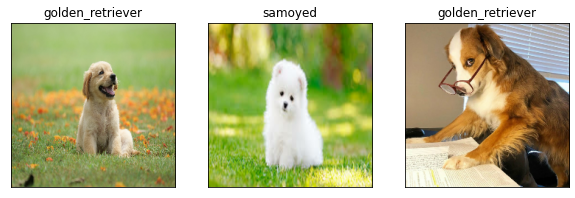

In [94]:
# Check custom image predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1,3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

# How can we improve the model itself?

1. Trying another model from TensorFlow Hub
2. Data augmentation
3. Fine-tuning
4. Google!!!  